In [1]:
%matplotlib inline
import warnings  
warnings.filterwarnings('ignore')

import os
import json
import glob
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objs as go

from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# [0] 파일 불러오기
다운샘플링된 point cloud는 아래의 data tree로 구성된 json 파일로 제공됩니다.
```
data
  ├ train
  │    ├ "points" : train point cloud ( 5000, (약 1000 x 3) )
  │    └ "label"  : 0 ~ 9 ( classification ) 
  └ test
        └ "points" : test point cloud ( 1000, (약 1000 x 3) )
```

## MNIST 3D Dataset
​
MNIST 3D Dataset의 클래스는 10개(0 ~ 9)의 숫자로 구성됩니다.  
​
텀 프로젝트에서는 원본을 downsampling 하여 가공한 약 1000 여 개의 point cloud로 변환하여 제공합니다.  

In [2]:
with open("mnist3D_data.json", 'r') as j:
    data = json.load(j)

## (cf) point cloud 시각화
​
해당 셀에서는 graph_objs 라이브러리를 통해 제공되는 Raw 데이터가 어떻게 구성되어 있는지 3차원으로 시각화하여 확인할 수 있습니다.  
​
여러 방향으로 드래그 하여 여러 시각에서 데이터를 보는 것이 가능합니다.  

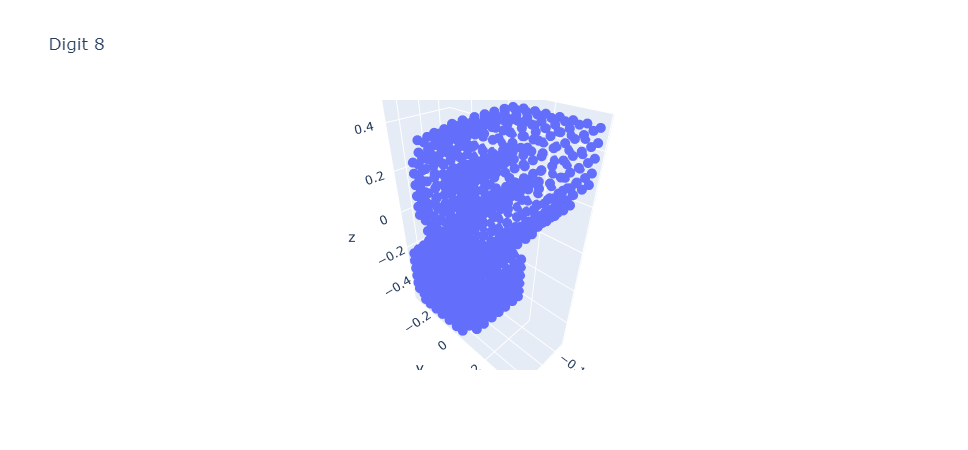

In [39]:
# 1720 번째 이미지에 대한 출력
image_number = 1000

digit = data["train"][image_number]["label"]
coordinate = np.array(data["train"][image_number]["points"])

layout = go.Layout(title = "Digit " + str(digit))
plot_data = go.Scatter3d(x = coordinate[:,0], y = coordinate[:,1], z = coordinate[:,2],
                    mode = 'markers', marker = dict(size = 3))

fig = go.Figure(data = [plot_data], layout = layout)
fig.show()

# [1] Data Loader
> 이번 실습문제에서는 3D 데이터를 Voxel 단위로 나눈 후, 이로부터 Feature를 추출하며 이를 기반으로 각 클래스를 분류합니다.  
> 클래스는 0부터 9까지 10가지로 분류됩니다.  

In [4]:
from torch.utils.data import Dataset

class MnistDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.data = data[mode]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        xyz = np.array(self.data[idx]['points'], dtype=np.float32)
        return {'points':xyz, 'label':self.data[idx]['label']}

# [2] Data Processing : Voxelization
​
​
아래에는 Raw 데이터를 Voxel_Grid에 맞춰 Voxelization을 진행한 후, 이를 기반으로 Feature를 추출하기 위한 함수를 정의하였습니다.  
​
※ 주의사항: Voxelization 시 ( 8, 8, 8 ) 사이즈의 Voxel을 사용합니다.  

In [5]:
# Voxel Grid 생성
# 목표 : point_cloud를 사용자가 지정한 voxel_size 크기의 voxel_grid로 분할한다

def VoxelGrid(points, voxel_size=[1, 1, 1]):

    # Voxel Grid를 구하기 위해 각 축 별 최대, 최소값 계산
    min_xyz  = np.min(points, axis=0) - 0.001
    max_xyz  = np.max(points, axis=0) + 0.001

    diff = max(max_xyz - min_xyz ) - ( max_xyz - min_xyz )
    min_xyz  = min_xyz  - diff / 2
    max_xyz  = max_xyz  + diff / 2

    # voxel_grid
    voxel_grid = []

    # point cloud를 각 축 (x,y,z) 에 대한 voxel grid 로 분할
    for i in range(3):
        # Voxel_size는 정수만 가능
        if type(voxel_size[i]) is not int:
            raise TypeError("voxel_size[{}] must be int".format(i))
        segment = np.linspace( min_xyz[i], max_xyz[i], num=(voxel_size[i] + 1))
        voxel_grid.append(segment)

    return voxel_grid # 생성한 voxel_grid 를 반환

In [6]:
# Voxelization (복셀화) 및 Voxel_Vector 추출
# 목표: 생성한 voxel_grid에 맞추어 point cloud를 각 grid에 맞춰 Voxelization하고, 이를 통해 voxel_vector 

def VoxelVector(points, voxel_grid, voxel_size=[1, 1, 1]):

    n_voxels = voxel_size[0] * voxel_size[1] * voxel_size[2]
    n_x = voxel_size[0]
    n_y = voxel_size[1]
    n_z = voxel_size[2]

    voxelization = np.zeros((len(points), 4), dtype=int)

    # Voxelization
    voxelization[:,0] = np.searchsorted(voxel_grid[0], points[:,0]) - 1
    voxelization[:,1] = np.searchsorted(voxel_grid[1], points[:,1]) - 1
    voxelization[:,2] = np.searchsorted(voxel_grid[2], points[:,2]) - 1

    voxelization[:,3] = ((voxelization[:,1] * n_x) + voxelization[:,0]) + (voxelization[:,2] * (n_x * n_y)) 

    # Voxelization으로부터 voxel_vector 추출
    vector = np.zeros(n_voxels)
    count = np.bincount(voxelization[:,3])
    vector[:len(count)] = count

    vector = vector.reshape(n_z, n_y, n_x)

    return vector # 추출한 Vector 반환


In [7]:
# Voxel_Feature 추출
# 목표: 추출한 voxel_vector로부터 classification에 feature로 활용할 수 있는 voxel_feature를 추출한다

def VoxelFeature(dataset):
    
    voxel_vectors = []
    labels = []

    for i, pc in enumerate(tqdm(dataset)):

        # point cloud를 np.array(dtype=np.float32)로 변경
        pointcloud = np.array(pc['points'], dtype = np.float32)   

        voxel_grid = VoxelGrid(pointcloud, voxel_size=[8, 8, 8])
        
        vector = VoxelVector(pointcloud, voxel_grid, voxel_size=[8, 8, 8])

        voxel_vectors.append(vector.reshape(-1) / np.max(vector))
        
        labels.append(pc['label'])

    return np.array(voxel_vectors), np.array(labels)

# [3] Model / Evauation

In [8]:
# [1] 데이터 불러온 후
mnist_train = MnistDataset(data, mode = "train")
mnist_test = MnistDataset(data, mode = "test")

# [2] 불러온 Raw 데이터를 가공합니다.
x_train, y_train = VoxelFeature(mnist_train)
x_test, _ = VoxelFeature(mnist_test)

In [9]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(5000, 512)
(5000,)
(1000, 512)


In [10]:
sc=MinMaxScaler()
x_train_sc= sc.fit_transform(x_train)
x_test_sc=sc.transform(x_test)

In [35]:
model=LinearSVC(C=0.1, max_iter = 100000, class_weight = 'balanced')
model.fit(x_train_sc,y_train)
model2= SVC(kernel = 'rbf', C=10, class_weight='balanced', gamma = 0.1)
model2.fit(x_train_sc,y_train)
print(model.score(x_train_sc, y_train))
print(model2.score(x_train_sc, y_train))

0.9358
1.0


In [36]:
pred_y = model2.predict(x_test_sc)

In [37]:
submit = pd.read_csv('submission.csv')

In [38]:
submit['Label']=pred_y
submit.to_csv('submission.csv', index=False)